In [12]:

# %pip install geopandas
# %pip install shapely
# %pip install pygeos
# %pip install tensorflow-cpu
# %pip install tensorflow-data-validation
# %pip install tensorflow-transform
# %pip install tensorflow-model-analysis
# %pip install scikit-learn
# %pip install scipy
# %pip install matplotlib
# %pip install python-dotenv
# %pip install seaborn

In [13]:
import os
import pandas as pd
import geopandas as gpd
import pygeos as pg
import numpy as np
import tensorflow as tf
import tensorflow_data_validation as tfdv
import sklearn as sk
import scipy as sp
import seaborn as sns
from IPython.display import clear_output
from matplotlib import pyplot as plt
from shapely import wkt

In [14]:
# The following lines adjust the granularity of reporting.
#pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
os.chdir('F:\\Uni Files\\4710\\4710 Project\\MLweatherForestFire')

In [15]:
def getGPDfromPD(df: pd.DataFrame, geomCol: str, crs: str = "EPSG:3978") -> gpd.GeoDataFrame:
    """
    Convert a pandas dataframe to a geopandas dataframe
    :param df: pandas dataframe
    :param geomCol: name of the geometry column
    :param crs: coordinate reference system
    :return: geopandas dataframe
    """
    if 'geom' in df.columns:
        df.rename(columns={'geom': 'geometry'}, inplace=True)

    df[geomCol] = df[geomCol].apply(wkt.loads)
    gdf = gpd.GeoDataFrame(df, geometry=geomCol, crs=crs)
    return gdf

In [16]:
provinces = "Data/GEOProvincialBoundaries.csv"
dfProvinces = pd.read_csv(provinces)
dfProvinces['geom'] = dfProvinces['geom'].apply(wkt.loads)
gdfProvinces = gpd.GeoDataFrame(dfProvinces, geometry='geom', crs="EPSG:3347")
del dfProvinces
del provinces

In [17]:
# Load fire data
fireTable = "Data/GEOSKFFWENearestStation.csv"
dfFire = pd.read_csv(fireTable)
dfFire['geom'] = dfFire['geom'].apply(wkt.loads)
gdfFire = gpd.GeoDataFrame(dfFire, geometry='geom', crs="EPSG:3347")
del dfFire
del fireTable

<AxesSubplot: >

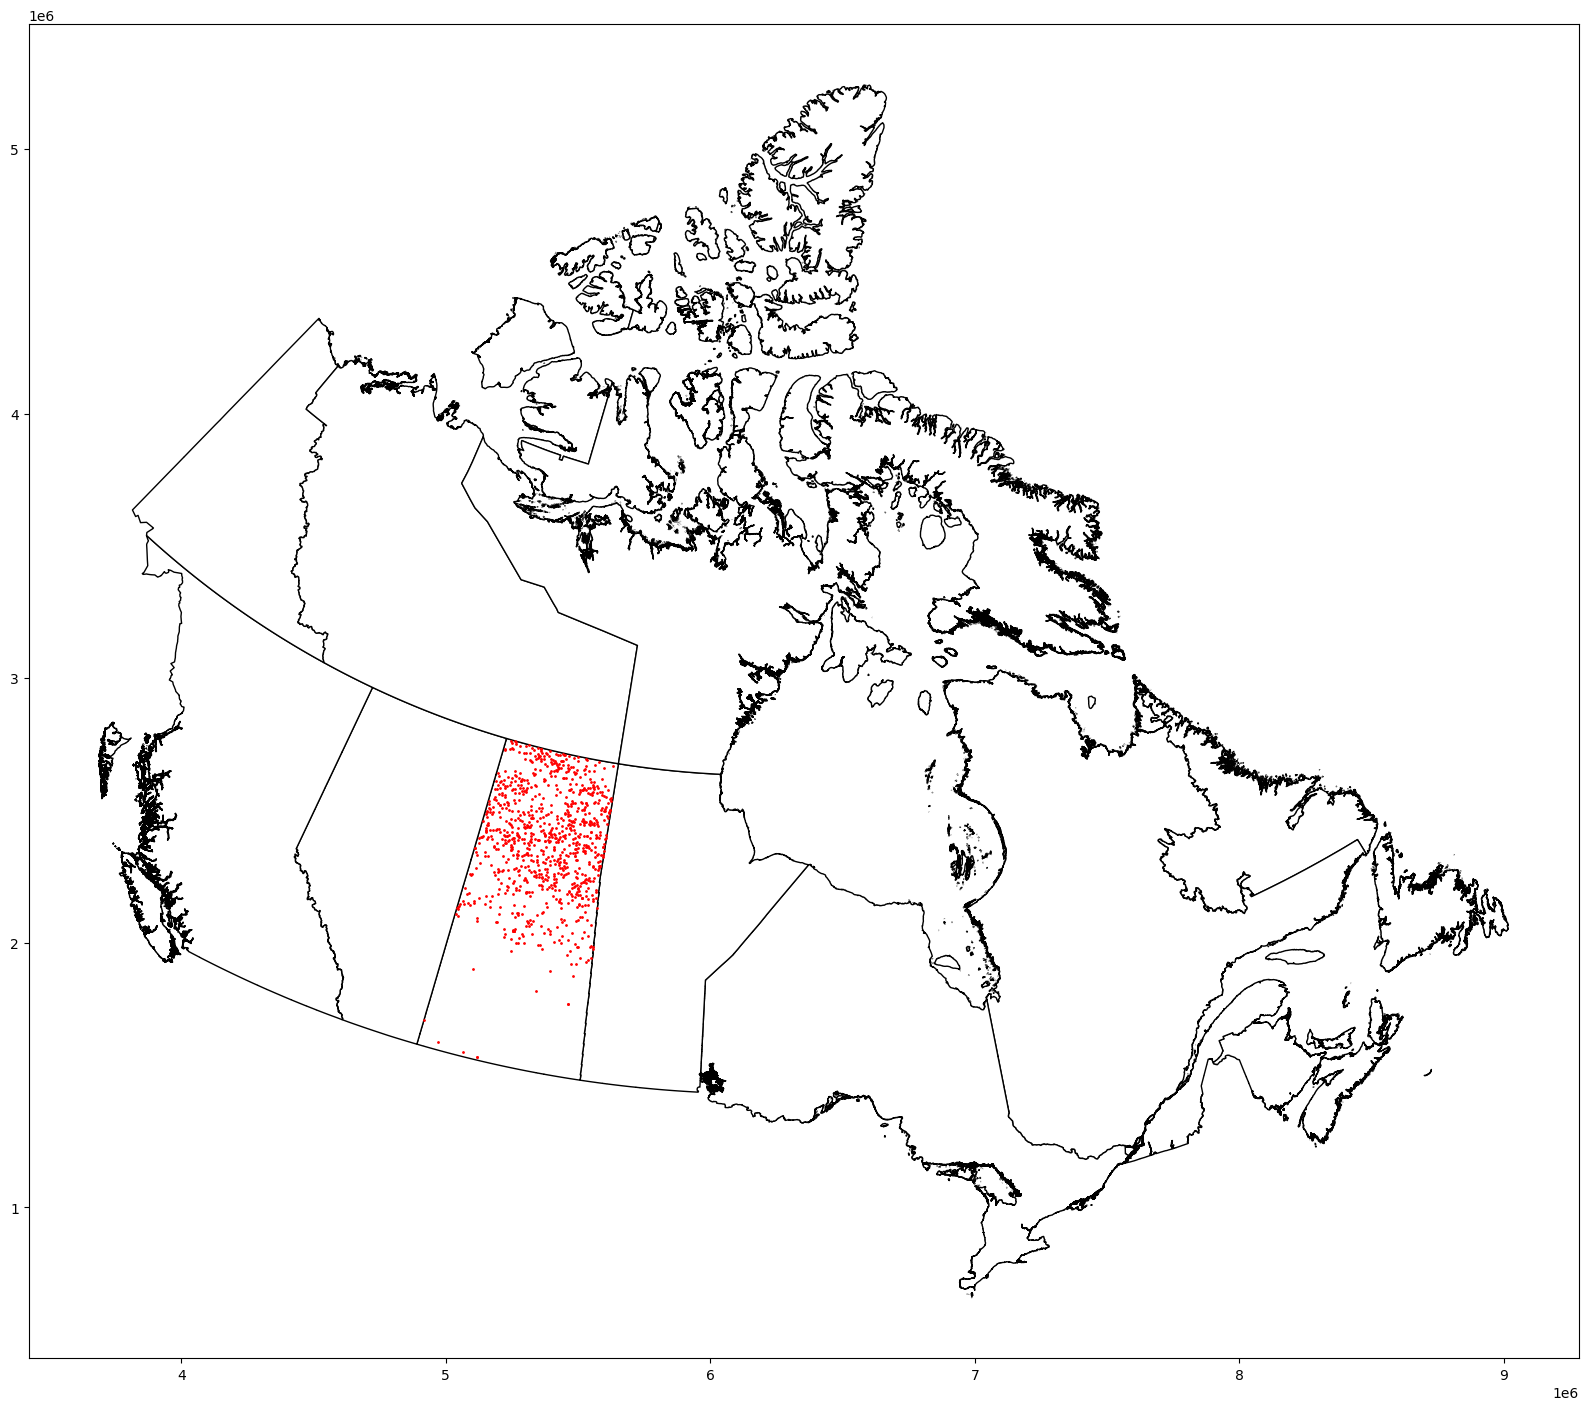

In [18]:
##### plot both to check
fig, ax = plt.subplots(figsize=(20, 20))
gdfProvinces.plot(ax=ax, color='white', edgecolor='black')
gdfFire.plot(ax=ax, color='red', markersize=1)


In [19]:
dailyWeather = "Data/WeatherDataHourlyAggDaily.csv"
dfWeather = pd.read_csv(dailyWeather)
dfWeather.columns

C:\Users\Red\AppData\Local\Temp\ipykernel_165964\2291072772.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  dfWeather = pd.read_csv(dailyWeather)


Index(['ClimateID', 'ProvinceCode', 'Year', 'Month', 'Day', 'MeanTemp',
       'MinTemp', 'MaxTemp', 'MeanDewPoint', 'MinDewPoint', 'MaxDewPoint',
       'MeanHumidity', 'MinHumidity', 'MaxHumidity', 'MeanPressure',
       'MinPressure', 'MaxPressure', 'MeanWindSpeed', 'MinWindSpeed',
       'MaxWindSpeed', 'MeanWindChill', 'MinWindChill', 'MaxWindChill',
       'TotalPrecip', 'MeanWindDirection'],
      dtype='object')

In [20]:
dfWeather.astype({'ClimateID': 'str', 'ProvinceCode': 'str', 
                'Year': 'int', 'Month': 'int', 'Day': 'int',
                'MeanTemp': 'float', 'MinTemp': 'float', 'MaxTemp': 'float',
                'MeanDewPoint': 'float', 'MinDewPoint': 'float', 'MaxDewPoint': 'float',
                'MeanHumidity': 'float', 'MinHumidity': 'float', 'MaxHumidity': 'float',
                'MeanPressure': 'float', 'MinPressure': 'float', 'MaxPressure': 'float',
                'MeanWindSpeed': 'float', 'MinWindSpeed': 'float', 'MaxWindSpeed': 'float',
                'MeanWindChill': 'float', 'MinWindChill': 'float', 'MaxWindChill': 'float',
                'TotalPrecip': 'float', 'MeanWindDirection': 'float'}, copy=False)
dfWeather.drop(columns=['MeanTemp', 'MinTemp', 'MeanDewPoint', 'MinDewPoint', 'MaxDewPoint',
                    'MinHumidity', 'MaxHumidity', 'MeanPressure', 'MinPressure',
                    'MaxPressure', 'MinWindSpeed', 'MeanWindChill', 'MinWindChill', 'MaxWindChill',
                    'MeanWindDirection' ], inplace=True)

In [21]:
print(dfWeather.columns)
print(gdfFire.columns)

Index(['ClimateID', 'ProvinceCode', 'Year', 'Month', 'Day', 'MaxTemp',
       'MeanHumidity', 'MeanWindSpeed', 'MaxWindSpeed', 'TotalPrecip'],
      dtype='object')
Index(['EntryID', 'FIRE_ID', 'FIRENAME', 'YEAR', 'MONTH', 'DAY', 'REP_DATE',
       'SIZE_HA', 'size_ha_bin', 'geom', 'ElevationM', 'Dist_To_Water',
       'Climate ID', 'distance'],
      dtype='object')


In [22]:
gdfFire.rename(columns={'Climate ID': 'ClimateID'}, inplace=True)
gdfFire.drop(columns=['distance'], inplace=True)
dfWeather.rename(columns={'Day': 'DAYW'}, inplace=True)

In [23]:
# make column names all caps
dfWeather.columns = map(str.upper, dfWeather.columns)
gdfFire.columns = map(str.upper, gdfFire.columns)

In [24]:
dfWeather['CLIMATEID'] = dfWeather['CLIMATEID'].astype(str)
gdfFire['CLIMATEID'] = gdfFire['CLIMATEID'].astype(str)

In [25]:
# join dfAll plus weather

dfFireWeather = gdfFire.copy(deep=True)

# left join dfAll and dfWeatherDaily on ClimateID and YEAR and MONTH
dfFireWeather = dfFireWeather.merge(dfWeather, on=['CLIMATEID', 'MONTH', 'YEAR'], how='left')
print(dfFireWeather.head())
# keep only rows where utcWeather = utcFire - ONEDAY
dfFireWeather = dfFireWeather[(dfFireWeather['DAYW'] == dfFireWeather['DAY'] - 1)]

print(dfFireWeather.columns)
print(gdfFire.count())
print(dfFireWeather.count())


   ENTRYID       FIRE_ID      FIRENAME  YEAR  MONTH  DAY    REP_DATE  SIZE_HA  \
0      283  15HB-VEILLAR  15HB-VEILLAR  2015      4   29  2015-04-29    379.5   
1      283  15HB-VEILLAR  15HB-VEILLAR  2015      4   29  2015-04-29    379.5   
2      283  15HB-VEILLAR  15HB-VEILLAR  2015      4   29  2015-04-29    379.5   
3      283  15HB-VEILLAR  15HB-VEILLAR  2015      4   29  2015-04-29    379.5   
4      283  15HB-VEILLAR  15HB-VEILLAR  2015      4   29  2015-04-29    379.5   

   SIZE_HA_BIN                             GEOM  ELEVATIONM  DIST_TO_WATER  \
0            0  POINT (5493369.251 1920171.023)       568.0        13389.6   
1            0  POINT (5493369.251 1920171.023)       568.0        13389.6   
2            0  POINT (5493369.251 1920171.023)       568.0        13389.6   
3            0  POINT (5493369.251 1920171.023)       568.0        13389.6   
4            0  POINT (5493369.251 1920171.023)       568.0        13389.6   

  CLIMATEID PROVINCECODE  DAYW  MAXTEMP  MEA

In [26]:
dfFireWeather.describe()

,ENTRYID,YEAR,MONTH,DAY,SIZE_HA,SIZE_HA_BIN,ELEVATIONM,DIST_TO_WATER,DAYW,MAXTEMP,MEANHUMIDITY,MEANWINDSPEED,MAXWINDSPEED,TOTALPRECIP
count,857.0,857.0,857.0,857.0,857.0,857.0,857.0,857.0,857.0,850.0,836.0,857.0,857.0,857.0
mean,1148.9,2009.6,6.4,16.8,10550.4,1.7,740.8,3862.1,15.8,23.1,61.2,8.1,16.0,0.2
std,1424.9,5.4,1.1,9.0,29102.0,1.1,511.8,4085.4,9.0,6.3,12.1,3.5,6.1,1.5
min,283.0,2000.0,1.0,2.0,201.8,0.0,225.0,0.0,1.0,-6.2,28.0,0.0,0.0,0.0
25%,527.0,2005.0,6.0,9.0,698.2,1.0,434.0,1087.0,8.0,21.1,53.0,5.7,11.0,0.0
50%,757.0,2010.0,6.0,18.0,2034.0,2.0,496.0,2460.6,17.0,24.5,61.0,7.5,15.0,0.0
75%,1548.0,2015.0,7.0,25.0,7114.5,3.0,1161.0,5260.1,24.0,27.0,68.6,10.1,20.0,0.0
max,10650.0,2020.0,10.0,31.0,476376.8,3.0,3668.0,29418.8,30.0,34.9,96.9,30.1,37.0,20.8


In [28]:
# print rows with NaN values
print(dfFireWeather[dfFireWeather.isna().any(axis=1)])

       ENTRYID        FIRE_ID       FIRENAME  YEAR  MONTH  DAY    REP_DATE  \
6153       503         E64003      06LF-GULL  2006      6   30  2006-06-30   
7496       548         L61040   06LA-ENGLISH  2006      6   30  2006-06-30   
7582       551         L61038     06LA-BLACK  2006      6   30  2006-06-30   
7666       554         L61037  06LA-MCNICHOL  2006      6   30  2006-06-30   
7694       555         L61042    06LA-RAPIDS  2006      6   30  2006-06-30   
7722       556         L61041    06LA-GRANNY  2006      6   30  2006-06-30   
8111       569         L62037    06PN-CREEK1  2006      6   30  2006-06-30   
25350     1770     18LA-BRIAN     18LA-BRIAN  2018      7   11  2018-07-11   
25454     1773     18LA-WOODS     18LA-WOODS  2018      6   18  2018-06-18   
25763     1783  18SR-FONTAINE  18SR-FONTAINE  2018      6   22  2018-06-22   
25789     1784  18SR-MARGETTS  18SR-MARGETTS  2018      6   18  2018-06-18   
25854     1786    18LX-TIMSON    18LX-TIMSON  2018      6   22  

In [29]:
# drop rows with NaN values
dfFireWeather.dropna(inplace=True)

In [36]:
# dfFireWeather['GEOM'] = dfFireWeather['GEOM'].apply(wkt.loads)
gdfFireWeather = gpd.GeoDataFrame(dfFireWeather, geometry='GEOM', crs="EPSG:3347")

In [37]:
gdfFireWeather['RAIN'] = (gdfFireWeather['TOTALPRECIP'] > 0).astype(bool)
gdfFireWeather['LONG'] = gdfFireWeather['GEOM'].x
gdfFireWeather['LAT'] = gdfFireWeather['GEOM'].y

In [39]:
# create longitude binned column
gdfFireWeather['LONGBIN'], longBins = pd.cut(gdfFireWeather['LONG'], 570, labels=False, retbins=True)
gdfFireWeather['LATBIN'], latBins = pd.cut(gdfFireWeather['LAT'], 570, labels=False, retbins=True)
print(gdfFireWeather.head())
print(gdfFireWeather.count())
print(longBins)
print(latBins)

     ENTRYID       FIRE_ID      FIRENAME  YEAR  MONTH  DAY    REP_DATE  \
27       283  15HB-VEILLAR  15HB-VEILLAR  2015      4   29  2015-04-29   
40       284   15PA-SLIR05   15PA-SLIR05  2015      5   11  2015-05-11   
74       285   15SR-BLIB01   15SR-BLIB01  2015      5   15  2015-05-15   
113      286    15LF-TORCH    15LF-TORCH  2015      5   22  2015-05-22   
140      287   15DN-DIVIDE   15DN-DIVIDE  2015      5   21  2015-05-21   

     SIZE_HA  SIZE_HA_BIN                             GEOM  ELEVATIONM  \
27     379.5            0  POINT (5493369.251 1920171.023)       568.0   
40     246.2            0  POINT (5277587.973 2017537.434)       488.0   
74     651.7            1  POINT (5444021.740 2622811.110)       293.0   
113   1317.2            1  POINT (5407262.796 2004502.842)       373.0   
140    516.8            1  POINT (5118639.274 2095010.666)      2156.0   

     DIST_TO_WATER CLIMATEID PROVINCECODE  DAYW  MAXTEMP  MEANHUMIDITY  \
27         13389.6   4064149        

f:\Programs\Miniconda3\envs\ml\lib\site-packages\pandas\plotting\_matplotlib\core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='LONGBIN', ylabel='LATBIN'>

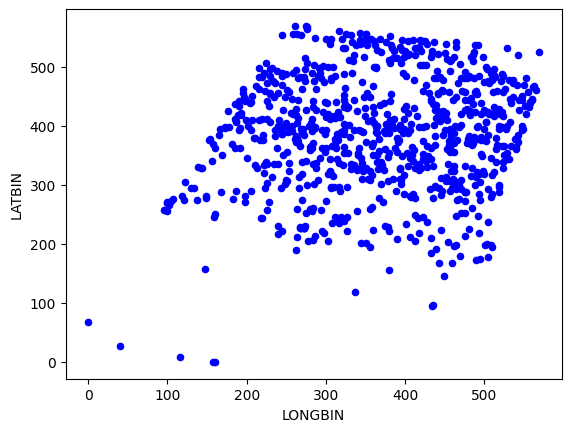

In [40]:
# plot LongitudeBin vs LatitudeBin scatter plot
gdfFireWeather.plot.scatter(x='LONGBIN', y='LATBIN', c='blue', colormap='viridis')


In [41]:
# save dfRain to csv
gdfFireWeather.to_csv('Data/FinalFeature.csv', index=False)